# Sentiment Analysis with BERT

## Importing libraries

In [1]:
!pip install transformers

In [2]:
from pyspark.sql import SparkSession

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

/Users/zaftyguy/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Data Sampling

In [3]:
spark = SparkSession.builder.appName("Data Sampling for BERT model").getOrCreate()
reviewsDF = spark.read.json("data/yelp_academic_dataset_review.json")
reviewsDF.createOrReplaceTempView("review")

filtered_df = spark.sql("""
                        SELECT review_id, text, stars
                        FROM review
                        """)

filtered_df.show()

#randomly selecting data
sample_size = 10000
sampled_df = filtered_df.sample(withReplacement=False, fraction=sample_size/filtered_df.count(), seed=3)

pandasDF = sampled_df.toPandas()
pandasDF.head()

spark.stop()

25/05/16 20:59:20 WARN Utils: Your hostname, Justins-MacBook-Pro-5.local resolves to a loopback address: 127.0.0.1; using 100.64.11.184 instead (on interface en0)
25/05/16 20:59:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/16 20:59:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+--------------------+-----+
|           review_id|                text|stars|
+--------------------+--------------------+-----+
|KU_O5udG6zpxOg-Vc...|If you decide to ...|  3.0|
|BiTunyQ73aT9WBnpR...|I've taken a lot ...|  5.0|
|saUsX_uimxRlCVr67...|Family diner. Had...|  3.0|
|AqPFMleE6RsU23_au...|Wow!  Yummy, diff...|  5.0|
|Sx8TMOWLNuJBWer-0...|Cute interior and...|  4.0|
|JrIxlS1TzJ-iCu79u...|I am a long term ...|  1.0|
|6AxgBCNX_PNTOxmbR...|Loved this tour! ...|  5.0|
|_ZeMknuYdlQcUqng_...|Amazingly amazing...|  5.0|
|ZKvDG2sBvHVdF5oBN...|This easter inste...|  3.0|
|pUycOfUwM8vqX7KjR...|Had a party of 6 ...|  3.0|
|rGQRf8UafX7OTlMNN...|My experience wit...|  5.0|
|l3Wk_mvAog6XANIuG...|Locals recommende...|  4.0|
|XW_LfMv0fV21l9c6x...|Love going here f...|  4.0|
|8JFGBuHMoiNDyfcxu...|Good food--loved ...|  4.0|
|UBp0zWyH60Hmw6Fsa...|The bun makes the...|  4.0|
|OAhBYw8IQ6wlfw1ow...|Great place for b...|  5.0|
|oyaMhzBSwfGgemSGu...|Tremendous servic...|  5.0|


## BERT Tokenization

In [9]:
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 6
LEARNING_RATE = 1e-3

/var/folders/5m/n3lmdh1d5bl0t6d_1p3n_2wh0000gn/T/ipykernel_90178/935480887.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

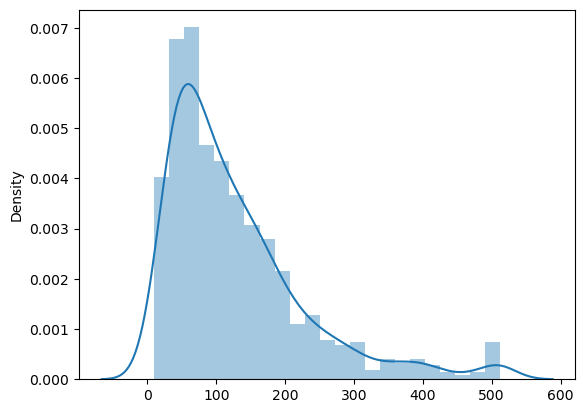

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_lens = []

for text in pandasDF['text'].sample(n=1000, random_state=3):
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)

Based on the distplot, we will pick a max_length of around 400 tokens.

In [6]:
texts = pandasDF['text'].tolist()
labels = pandasDF['stars'].tolist()

def tokenize_batch(texts, max_length=MAX_LENGTH):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=3, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=3, stratify=y_temp
)

train_encodings = tokenize_batch(X_train)
val_encodings = tokenize_batch(X_val)
test_encodings = tokenize_batch(X_test)

y_train = torch.tensor([label - 1 for label in y_train], dtype=torch.long)
y_val = torch.tensor([label - 1 for label in y_val], dtype=torch.long)
y_test = torch.tensor([label - 1 for label in y_test], dtype=torch.long)

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    y_train
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    y_val
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    y_test
)

## Creating Data Loader

In [7]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)

## Training Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False
)

# Updates model's weights
optimizer = AdamW(model.parameters(), lr= LEARNING_RATE, eps= 1e-8)
trainingSteps = len(train_dataloader) * EPOCHS

# Makes sure that learning rate doesn't overshoot by decreasing learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= 0,
                                           num_training_steps= trainingSteps)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model.to(device)
best_val_accuracy = 0

for i in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        
        if batch_idx % 5 == 0:
            print(f"Batch {batch_idx}/{len(train_dataloader)}")
            
        inputId = batch[0].to(device)
        attenMask = batch[1].to(device)
        batchLabel = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids= inputId, attention_mask= attenMask, labels= batchLabel)

        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(avg_train_loss)
    
    model.eval()
    total_val_loss = 0
    val_preds = []
    val_true = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            if batch_idx % 5 == 0:
                print(f"Batch {batch_idx}/{len(val_dataloader)}")
            
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_val_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_true, val_preds)
    print(f"  Validation loss: {avg_val_loss:.4f}")
    print(f"  Validation accuracy: {val_accuracy:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_bert_sentiment_model.pt")
        print("Model saved!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batch 0/440
Batch 5/440
Batch 10/440
Batch 15/440
Batch 20/440
Batch 25/440
Batch 30/440
Batch 35/440
Batch 40/440
Batch 45/440
Batch 50/440
Batch 55/440
Batch 60/440
Batch 65/440
Batch 70/440
Batch 75/440
Batch 80/440
Batch 85/440
Batch 90/440
Batch 95/440
Batch 100/440
Batch 105/440
Batch 110/440
Batch 115/440
Batch 120/440
Batch 125/440
Batch 130/440
Batch 135/440
Batch 140/440
Batch 145/440
Batch 150/440
Batch 155/440
Batch 160/440
Batch 165/440
Batch 170/440
Batch 175/440
Batch 180/440
Batch 185/440
Batch 190/440
Batch 195/440
Batch 200/440
Batch 205/440
Batch 210/440
Batch 215/440
Batch 220/440
Batch 225/440
Batch 230/440
Batch 235/440
Batch 240/440
Batch 245/440
Batch 250/440
Batch 255/440
Batch 260/440
Batch 265/440
Batch 270/440
Batch 275/440
Batch 280/440
Batch 285/440
Batch 290/440
Batch 295/440
Batch 300/440
Batch 305/440
Batch 310/440
Batch 315/440
Batch 320/440
Batch 325/440
Batch 330/440
Batch 335/440
Batch 340/440
Batch 345/440
Batch 350/440
Batch 355/440
Batch 360/440


In [ ]:
model.load_state_dict(torch.load("best_bert_sentiment_model.pt"))

model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        if batch_idx % 5 == 0:
                print(f"Batch {batch_idx}/{len(test_dataloader)}")
                
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
print(f"Test accuracy: {test_accuracy:.4f}")

In [ ]:
def get_predictions(texts):
    encodings = tokenize_batch(texts)
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
    logits = outputs.logits
    return torch.argmax(logits, dim=1).cpu().numpy() + 1

poke_reviews = pd.read_json("data/filtered_reviews_poke.json", lines=True)


batch_size = 32
predictions = []
total_batches = (len(poke_reviews) + batch_size - 1) // batch_size

for i in range(0, len(poke_reviews), batch_size):
    if i % (batch_size * 10) == 0:
        print(f"Processing batch {i//batch_size + 1}/{total_batches} ({i+1}-{min(i+batch_size, len(pandasDF))} of {len(pandasDF)} reviews)")
    
    batch_texts = poke_reviews['text'].iloc[i:i+batch_size].tolist()
    batch_preds = get_predictions(batch_texts)
    predictions.extend(batch_preds)


pandasDF['predicted_sentiment'] = predictions
print(pandasDF)

pandasDF.to_csv('sentiment_analysis_full_results.csv', index=False)